In [51]:
import csv
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from scipy.linalg import eigh
random.seed(37)

In [52]:

df = pd.read_csv('Payments.csv')
df = df.groupby(['Sender', 'Receiver'])['Amount'].sum().reset_index()
df = df.groupby(['Sender', 'Receiver'])['Amount'].mean().reset_index()
unique_names = set(df['Sender'].unique()).union(set(df['Receiver'].unique()))
name_to_int = {name: i+1 for i, name in enumerate(unique_names)}
df['Sender'] = df['Sender'].map(name_to_int)
df['Receiver'] = df['Receiver'].map(name_to_int)


In [53]:
G = nx.DiGraph()
for index, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    amount = row['Amount']
    if G.has_edge(sender, receiver):
        G[sender][receiver]['weight'] += amount
    else:
        G.add_edge(sender, receiver, weight=amount)


#################################################
#################################################
Node2Veec EEmbedding

In [54]:
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, node, walk_length))
    
    return walks

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            walk.append(random.choice(neighbors))
        else:
            break
    return walk

In [55]:
class SkipGram:
    def __init__(self, walks, embedding_size, window_size, learning_rate, epochs):
        self.walks = walks
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.vocab = list(set([node for walk in walks for node in walk]))
        self.word2index = {word: i for i, word in enumerate(self.vocab)}
        self.index2word = {i: word for word, i in self.word2index.items()}
        self.vocab_size = len(self.vocab)
        self.embeddings = np.random.randn(self.vocab_size, self.embedding_size)
    
    def train(self):
        for _ in range(self.epochs):
            for walk in self.walks:
                for i, target_node in enumerate(walk):
                    context = self.get_context(walk, i)
                    for context_node in context:
                        target_index = self.word2index[target_node]
                        context_index = self.word2index[context_node]
                        self.update(target_index, context_index)
    
    def update(self, target_index, context_index):
        target_embedding = self.embeddings[target_index]
        context_embedding = self.embeddings[context_index]
        error = context_embedding - target_embedding
        self.embeddings[target_index] += self.learning_rate * error
        self.embeddings[context_index] -= self.learning_rate * error
    
    def get_context(self, walk, index):
        start = max(0, index - self.window_size)
        end = min(len(walk), index + self.window_size)
        return [walk[i] for i in range(start, end) if i != index]

    def get_embeddings(self):
        return self.embeddings


In [56]:
num_walks = 10
walk_length = 20
random_walks = generate_random_walks(G, num_walks, walk_length)
embedding_size = 8
window_size = 10
learning_rate = 0.01
epochs = 10
skipgram = SkipGram(random_walks, embedding_size, window_size, learning_rate, epochs)
skipgram.train()

embeddings = skipgram.get_embeddings()

for i in range(5):
    print(f"Node {i}: {embeddings[i]}")


Node 0: [ 0.03513156 -0.01619262  0.02304745 -0.0094632  -0.01143577 -0.01854411
  0.00599514 -0.05064667]
Node 1: [ 0.03494353 -0.01676778  0.0226123  -0.00815657 -0.01098343 -0.0189049
  0.00603517 -0.05063855]
Node 2: [ 0.03504012 -0.0162332   0.02317148 -0.00922358 -0.0112494  -0.01850513
  0.00614821 -0.05075825]
Node 3: [ 0.03513738 -0.01621518  0.02346657 -0.0093121  -0.0110555  -0.01846636
  0.00607906 -0.05095427]
Node 4: [ 0.03487739 -0.01641086  0.02309481 -0.00926599 -0.01138914 -0.01838223
  0.006191   -0.05094374]


In [57]:
pca = PCA(n_components=3)
result = pca.fit_transform(embeddings)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


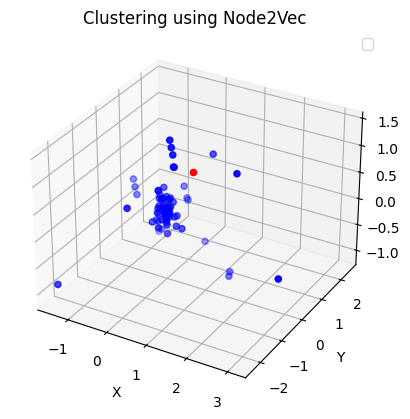

In [58]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
data = result

k = 2  
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'b'] 
for i in range(k):
    ax.scatter(data[labels == i][:, 0], data[labels == i][:, 1], data[labels == i][:, 2], c=colors[i], marker='o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Clustering using Node2Vec')
plt.legend()
plt.savefig('n2v.png')
plt.show()


#####################################
#####################################
Spectral Embeddings

In [59]:

nodes = sorted(set(df['Sender'].unique()).union(df['Receiver'].unique()))
adj_matrix = np.zeros((len(nodes), len(nodes)))

for _, row in df.iterrows():
    sender_idx = nodes.index(row['Sender'])
    receiver_idx = nodes.index(row['Receiver'])
    adj_matrix[sender_idx][receiver_idx] = row['Amount']

adj_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)



In [60]:

adjacency_matrix = adj_df
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
laplacian_matrix = degree_matrix - adjacency_matrix
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)

sorted_indices = np.argsort(eigenvalues)
sorted_indices = sorted_indices[::-1] 
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

spectral_embeddings = eigenvectors[:, 1:9] 


In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the node embeddings
pca = PCA(n_components=3)
result_s = pca.fit_transform(spectral_embeddings)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


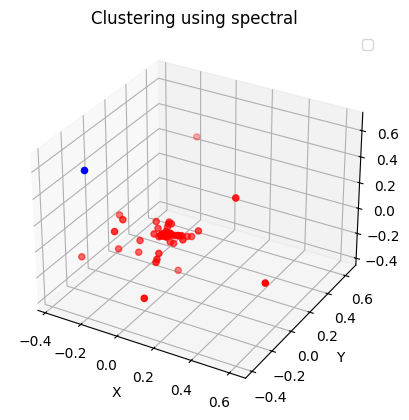

In [63]:




import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random 3D data
np.random.seed(0)
data = result_s

# Initialize k-means algorithm
k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the data points with colors representing the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'b']  # Color for each cluster
for i in range(k):
    ax.scatter(data[labels == i][:, 0], data[labels == i][:, 1], data[labels == i][:, 2], c=colors[i], marker='o')

# Plot the centroids

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Clustering using spectral')
plt.legend()
plt.savefig('Sp.png')
plt.show()


#################################
#################################
GCN

In [66]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx


df = pd.read_csv("Payments.csv")

G = nx.from_pandas_edgelist(df, 'Sender', 'Receiver', 'Amount', create_using=nx.DiGraph())

mapping = {node: i for i, node in enumerate(G.nodes)}
G = nx.relabel_nodes(G, mapping)

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G[u][v]['Amount'] for u, v in G.edges], dtype=torch.float)

num_nodes = len(G.nodes)
features = torch.eye(num_nodes) 
embed_dim = 8

class GCN(torch.nn.Module):
    def __init__(self, num_nodes, embed_dim):
        super(GCN, self).__init__()
        self.c1 = GCNConv(num_nodes,32)
        self.c2 = GCNConv(32, embed_dim)

    def forward(self, x, edge_index, edge_weight):
        x = F.dropout(F.relu(self.c1(x, edge_index, edge_weight)), training=self.training)
        return self.c2(x, edge_index, edge_weight)

def distance_loss(embeddings):
    dist_matrix = torch.cdist(embeddings, embeddings, p=2)
    return torch.mean(dist_matrix)




model = GCN(num_nodes, embed_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

x = torch.tensor(features, dtype=torch.float)

model.train()
for epoch in range(100):  # Train for 100 epochs or until convergence
    optimizer.zero_grad()
    out = model(x, edge_index, edge_weight)
    loss = distance_loss(out)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    model.eval()
    embeddings = model(x, edge_index, edge_weight).detach().numpy()

/tmp/ipykernel_18759/2307967621.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(features, dtype=torch.float)


In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)
result = pca.fit_transform(embeddings)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


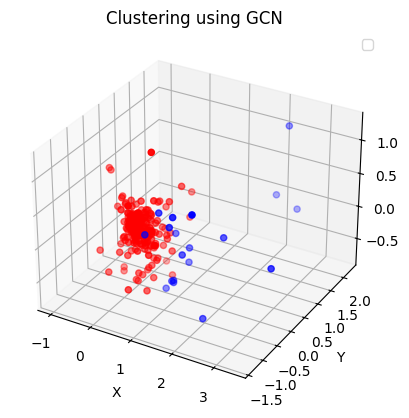

In [68]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
data = result

k = 2 
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'b']  # Color for each cluster
for i in range(k):
    ax.scatter(data[labels == i][:, 0], data[labels == i][:, 1], data[labels == i][:, 2], c=colors[i], marker='o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Clustering using GCN')
plt.legend()
plt.savefig('GCN')
plt.show()